In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(file_path=f'../datasets/100_yr_dataset.xlsx')

Downloaded 839 rows
Dataset loaded from ../datasets/100_yr_dataset.xlsx


In [3]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else x)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else x)
dataset.scv = df
df_old = df.copy()

In [4]:
if 'Agri' not in dataset.scv.columns:
    add_cols = ['Agri','AgriLag']

    # add cols to dataset by merging on PolityID and year from df_agri
    for col in add_cols:
        dataset.scv = dataset.scv.merge(df[['PolityID','Year',col]], on=['PolityID','Year'], how='left')


In [5]:
dataset.scv_imputed = pd.DataFrame([])
impute_cols = ['Pop','Terr','Cap','Hierarchy','Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(impute_cols, use_duplicates = False)
# dataset.scv['Hierarchy_sq'] = dataset.scv['Hierarchy']**2
# # impute scale and non scale variables separately
# scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
# dataset.impute_missing_values(scale_cols, use_duplicates = False)
# non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
# dataset.impute_missing_values(non_scale_cols, use_duplicates = False)

In [6]:
scale_cols = ['Pop','Terr','Cap']
dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
# rescale the PCA according to variable Pop


# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)

miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}

dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)

dataset.scv['IronCav'] = dataset.scv.apply(lambda row: row["Iron"] + row["Cavalry"], axis=1)

transfer_cols = ['Agri','AgriLag','Miltech','IronCav']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

Explained variance by each PC:
PC1: 92.03%
PC2: 6.46%
PC3: 1.50%


In [7]:
dataset.scv_imputed = dataset.scv_imputed.dropna(subset=['NGA'])

In [8]:
old_polities = df_old.PolityName.unique()
new_polities = dataset.scv_imputed.PolityName.unique()
print(len(old_polities), len(new_polities))
# find polities that are in the old dataset but not in the new dataset
missing_polities = [polity for polity in old_polities if polity not in new_polities]
common_polities = [polity for polity in old_polities if polity in new_polities]

# for polity in common_polities:
#     old_data = df_old[df_old.PolityName == polity]
#     new_data = dataset.scv_imputed[dataset.scv_imputed.PolityName == polity]
#     print(polity, len(old_data), len(new_data))

# for polity in missing_polities:
#     old_data = df_old[df_old.PolityName == polity]
#     print(polity, len(old_data))

373 373


In [83]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    # remove rows without a value 100 yrs later
    mask = (group['Year'] - group['Year'].shift(-1) != -100)
    indices = group.index.intersection(mask[mask].index)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan

In [84]:
x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2446.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:51:35   Log-Likelihood:                -956.07
No. Observations:                1419   AIC:                             1926.
Df Residuals:                    1412   BIC:                             1963.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.3385      0.056     23.841      0.0

(0.0, 0.95)

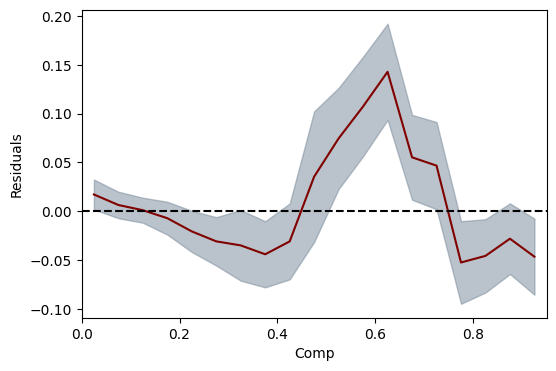

In [85]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size*2) & 
                (values < bin_center + bin_size*2))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals) / np.sqrt(len(bin_residuals))
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se,
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df

residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)
results_before = results.copy() 

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.xlim(0.0, 0.95)


In [93]:
thresh_start = np.arange(0.1, 0.5 , 0.01)
thresh_end = np.arange(0.5, 0.9, 0.01)
x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s) & (Xy.Comp < thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue
        }, ignore_index=True)



/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/317675927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/317675927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/317675927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X

In [94]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
print(thresh_min)
mask = (Xy.Comp >= thresh_min[0]) & (Xy.Comp < thresh_min[1])
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[0.48 0.69]
                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     2480.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:53:50   Log-Likelihood:                -947.11
No. Observations:                1419   AIC:                             1908.
Df Residuals:                    1412   BIC:                             1945.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.2752      0.058     22.

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3660150802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

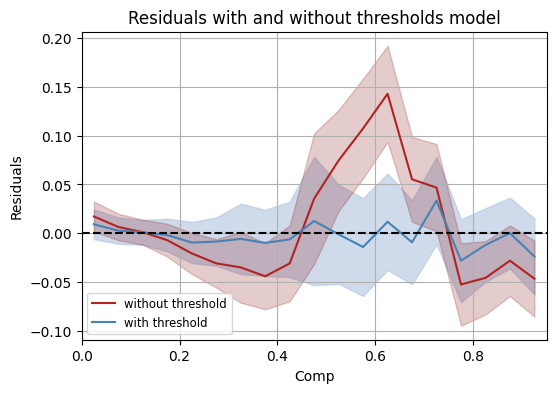

In [95]:
residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.05)
results = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

In [96]:
x_cols = ['Comp','Agri','AgriLag','IronCav','Scale_1','Comp_sq']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3163.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:54:40   Log-Likelihood:                 1538.5
No. Observations:                1419   AIC:                            -3063.
Df Residuals:                    1412   BIC:                            -3026.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           1.0637      0.038     28.153      0.0

(0.0, 9.0)

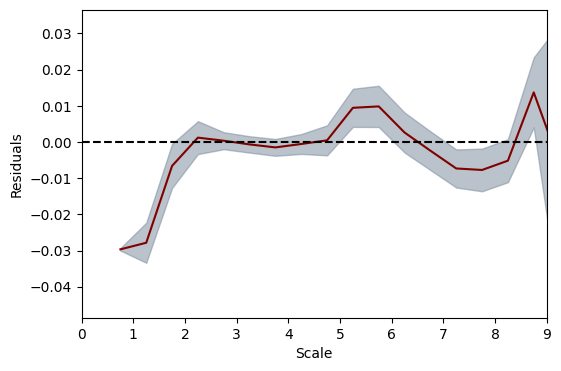

In [97]:
residuals = y['Comp_t'].values - predictions
scale_values = Xy['Scale_1'].values
bins = np.arange(0, 10, 0.5)

results = analyze_residuals(scale_values, residuals, bins)
results_before = results.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results['Value'], results['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(0.0, 9.)

In [98]:
thresh_start = np.arange(0, 5 , 0.1)
thresh_end = np.arange(3, 9, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s) & (Xy.Comp < thresh_e)
        X['Scale_1'] = 0
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue
        }, ignore_index=True)


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/477195710.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/477195710.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/477195710.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
print(thresh_min)

mask = (Xy.Comp >= thresh_min[0]) & (Xy.Comp < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

[0.8 3.3]
                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3199.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:55:42   Log-Likelihood:                 1545.9
No. Observations:                1419   AIC:                            -3078.
Df Residuals:                    1412   BIC:                            -3041.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1       -0.0494      0.012     -4.09

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/2350970143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


Text(0.5, 1.0, 'Residuals with and without thresholds model')

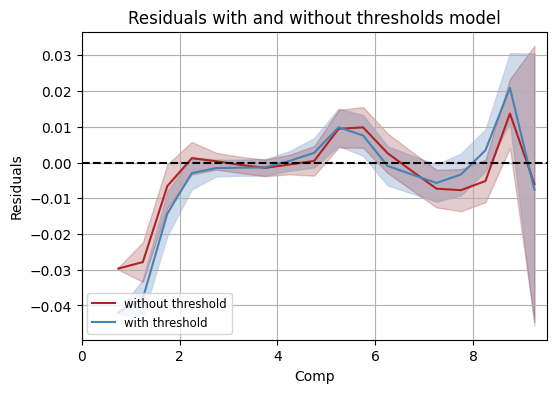

In [101]:
residuals = y['Comp_t'].values - predictions
scale_values = Xy['Scale_1'].values
bins = np.arange(0, 10, 0.5)
results = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_before['Value'], results_before['mean'], color='firebrick', label = 'without threshold')
plt.plot(results['Value'], results['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results['Value'], results['lower'], results['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_before['Value'], results_before['lower'], results_before['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 9.5)
#  add grid
plt.grid(True)
plt.title('Residuals with and without thresholds model')

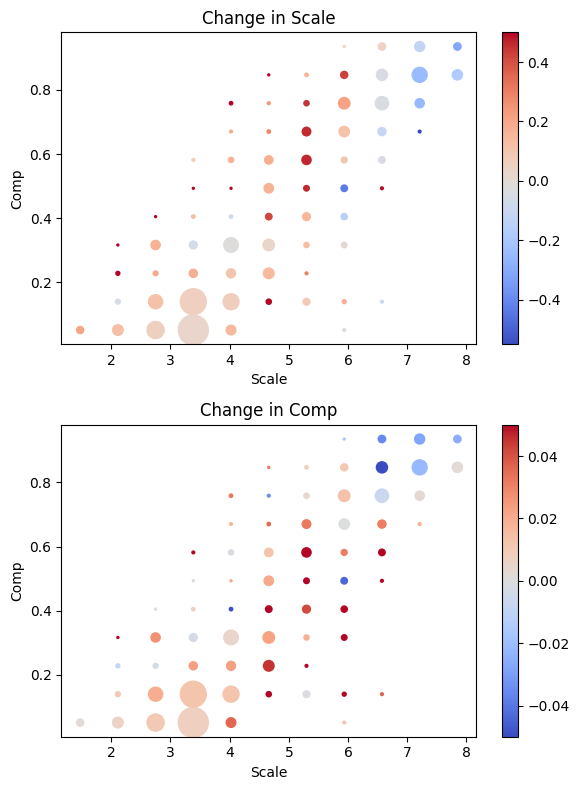

In [22]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3075141120.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


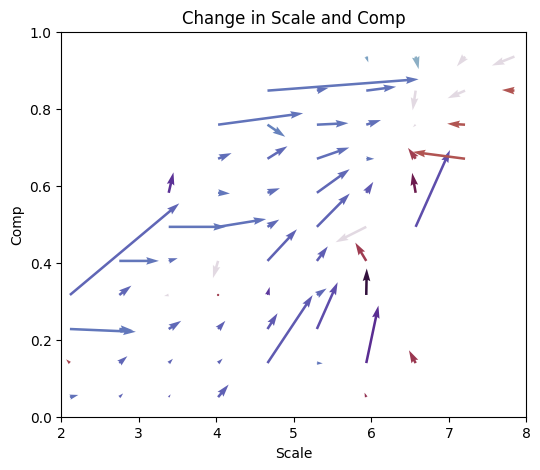

In [23]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 5))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3825249372.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3825249372.py:54: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3825249372.py:55: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_9762/3825249372.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = pl

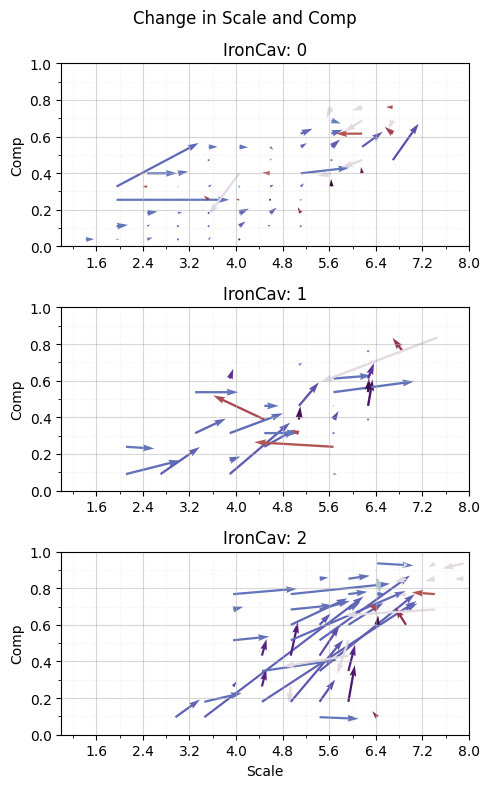

In [81]:
import seaborn as sns

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']

iron_cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(3,figsize=(5, 8))

# plt.minorticks_on()
for n,ic in enumerate(iron_cav):
    Xy = dr.loc[(dr.IronCav == ic) ]
    Xy = Xy[y_col+x_cols].dropna()
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[n].set_ylabel('Comp')
    ax[n].set_title(f'IronCav: {ic}')
    ax[n].grid(True,  alpha=0.5)
    ax[n].grid(True, which='major', alpha=0.5, linestyle='-')
    ax[n].grid(True, which='minor', alpha=0.1, linestyle='--')    
    ax[n].xaxis.set_major_locator(plt.MultipleLocator(0.80))
    ax[n].xaxis.set_minor_locator(plt.MultipleLocator(0.4))
    ax[n].yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax[n].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax[2].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()